# American Sign Language (ASL) Recognition 

In [25]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import skimage
from skimage.transform import resize

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from keras.layers.normalization import BatchNormalization

### Importing dataset

In [ ]:
paths = r'C:\Users\Chaitanya\Documents\LGM-Soc contributions\American Sign Language (ASL) Recognition\Dataset/train/'
for dirname, _, filenames in os.walk(r'C:\Users\Chaitanya\Documents\LGM-Soc contributions\American Sign Language (ASL) Recognition\Dataset/train/'):
    print(dirname)

In [10]:
categories = os.listdir(paths)
print("No. of categories of images in the train set = ",len(categories))

No. of categories of images in the train set =  29


#### Since this is a supervised learning approach to train the model we will have to label the images before giving it as input to the CNN model


In [14]:
def load_img_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        n = 0
        for image_name in os.listdir(paths+"/"+category):
            if n==100:
                break
                
            #load image data into an array
            img = cv2.imread(paths+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            
             #resizing the image
            resized_img = img_array.resize((200, 200))
            
            #converting the image array to numpy array before appending it to the list
            img_lst.append(np.array(resized_img))
            
            #appending label
            labels.append(index)
            
            n+=1
    return img_lst, labels

In [15]:
images, labels = load_img_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  2900 
No. of labels loaded =  2900
<class 'list'> <class 'list'>


#### Converting the images and labels into numpy arrays

In [16]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2900, 200, 200, 3) 
Labels shape =  (2900,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


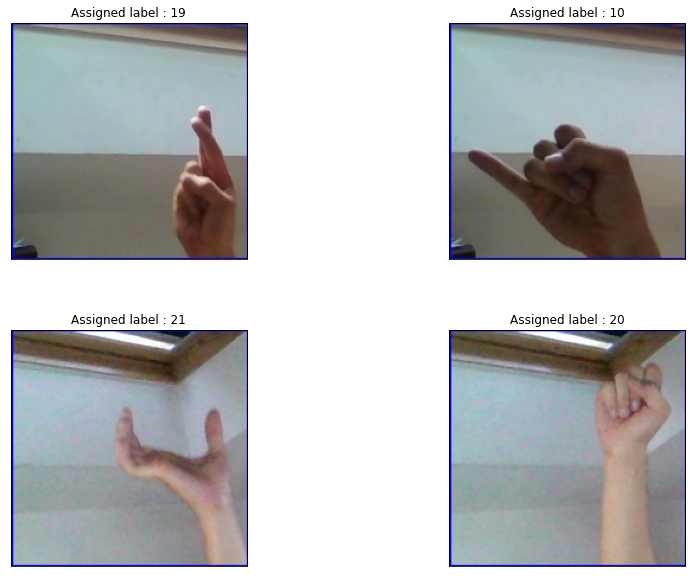

In [17]:
def display_label_images(images, labels):
    plt.figure(1 , figsize = (15 , 10))
    n = 0 
    for i in range(4):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(2, 2, n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
        plt.imshow(images[r[0]])
        
        plt.title('Assigned label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_label_images(images, labels)

### Generating X data and y data using Image augmentation approach

In [19]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29
train_len = 87000

In [20]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'nothing', 'space', 'del']


In [26]:
def data_generation(folder):
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int)
    i = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    
                    X[i] = img_arr
                    y[i] = classes.index(folderName)
                    i += 1
    return X,y
X, y = data_generation(paths)

In [27]:
print("X_data shape : ", X.shape)
print("y_data shape : ", y.shape)
print("Image shape : ", X[0].shape)

X_data shape :  (87000, 64, 64, 3)
y_data shape :  (87000,)
Image shape :  (64, 64, 3)


### Visualizing the X data --> sign language image and the y data --> label of the sign language

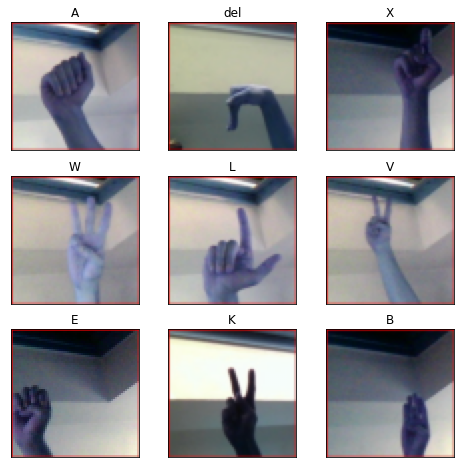

In [28]:
f, axs = plt.subplots(2,2,figsize=(8,8))
for i in range (0,9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(X))
    plt.imshow(X[img_nbr])
    plt.title(classes[y[img_nbr]])

### Data Processing

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

#### Performing One Hot Encoding on the categorical features of the training data

In [33]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train,29)
y_test_encoded = to_categorical(y_test,29)

### Verifying the dimensions of all variables before they are feeded to the models

In [35]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(60900, 64, 64, 3)
(60900,)
(26100, 64, 64, 3)
(26100,)
(60900, 29)
(26100, 29)


## Building the CNN model

In [44]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [45]:
model = Sequential([
    Conv2D(32, (5, 5), input_shape=(64, 64, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    tf.keras.layers.Dropout(rate=0.3),
    
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(29, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)       

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [47]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
history = model.fit(
    X_train, y_train_encoded,
    epochs=50,
    batch_size=64,
    verbose=2,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop]
)

Epoch 1/50
952/952 - 180s - loss: 1.2091 - accuracy: 0.6334 - val_loss: 0.3517 - val_accuracy: 0.8834
Epoch 2/50
952/952 - 218s - loss: 0.2347 - accuracy: 0.9219 - val_loss: 0.1454 - val_accuracy: 0.9533
Epoch 3/50
952/952 - 224s - loss: 0.1172 - accuracy: 0.9614 - val_loss: 0.0708 - val_accuracy: 0.9763
Epoch 4/50
952/952 - 222s - loss: 0.0761 - accuracy: 0.9747 - val_loss: 0.0588 - val_accuracy: 0.9808
Epoch 5/50
952/952 - 218s - loss: 0.0572 - accuracy: 0.9814 - val_loss: 0.0595 - val_accuracy: 0.9821
Epoch 6/50
952/952 - 222s - loss: 0.0463 - accuracy: 0.9852 - val_loss: 0.0317 - val_accuracy: 0.9911
Epoch 7/50
952/952 - 220s - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.0248 - val_accuracy: 0.9920
Epoch 8/50
952/952 - 217s - loss: 0.0331 - accuracy: 0.9891 - val_loss: 0.0229 - val_accuracy: 0.9921
Epoch 9/50
952/952 - 216s - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.0175 - val_accuracy: 0.9940
Epoch 10/50
952/952 - 201s - loss: 0.0274 - accuracy: 0.9917 - val_loss: 0.0336 - 

In [50]:
history_df = pd.DataFrame(history.history)

#### Plotting the accuracy and validation accuracy

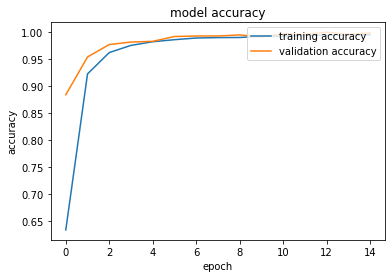

In [60]:
history_df.loc[0:, ['accuracy','val_accuracy']].plot()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper right')
plt.show()

#### Plotting the loss and validation loss

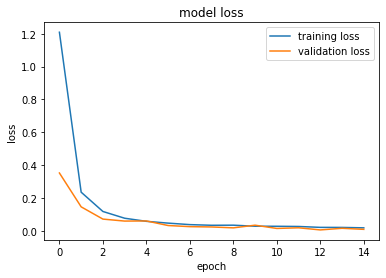

In [61]:
history_df.loc[0:, ['loss', 'val_loss']].plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

### After training and testing the CNN model we can conclude that it reaches a training accuracy of 99.43% and validation accuracy of 99.78% which shows that the CNN model has gained a very high precision.

### Performing multiclass predictions

In [54]:
predictions = np.argmax(model.predict(X_test), axis=-1)

In [55]:
predictions

array([ 5,  7,  3, ..., 17, 24, 25], dtype=int64)

### Comparing the Actual label vs the Predicted label of the Sign Language image

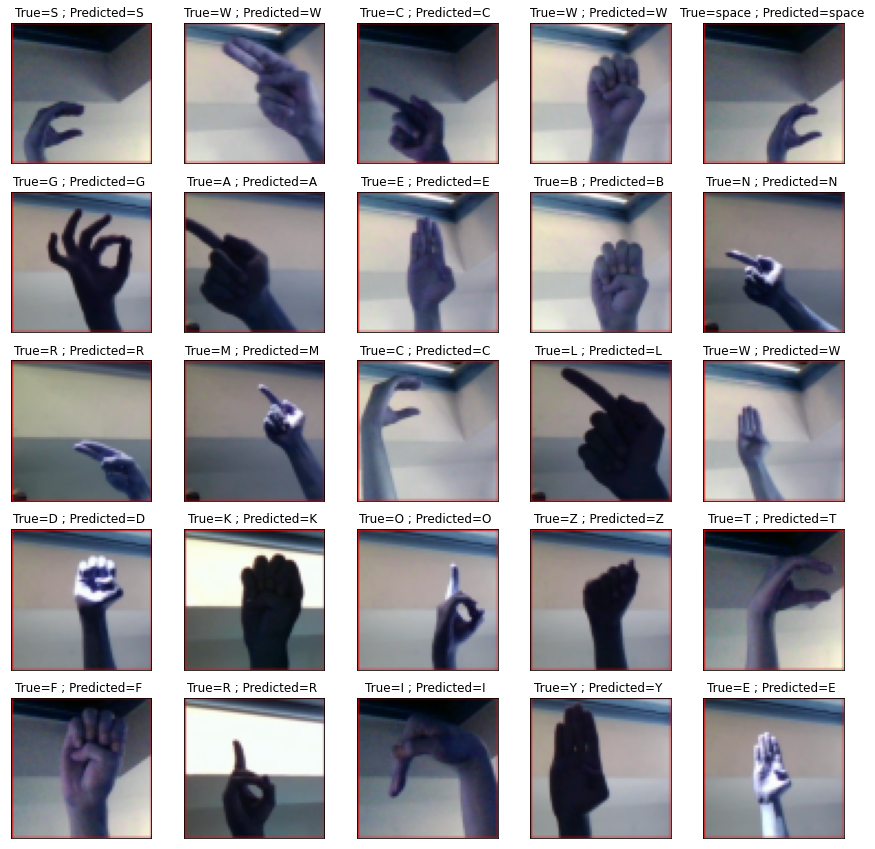

In [57]:
f, axs = plt.subplots(2,2,figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img_nbr = np.random.randint(0,len(predictions))
    plt.imshow(X[img_nbr])
    plt.title("True={} ; Predicted={} ".format(classes[(y_test[img_nbr])], classes[(predictions[img_nbr])]))

### Confusion Matrix 

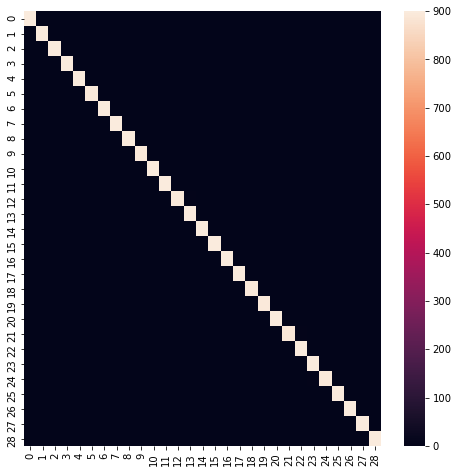

In [58]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,predictions))
plt.show()

### Classification report of the CNN model

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       900
           1       1.00      1.00      1.00       900
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       900
           4       0.99      1.00      1.00       900
           5       1.00      0.99      1.00       900
           6       1.00      1.00      1.00       900
           7       1.00      1.00      1.00       900
           8       0.99      1.00      1.00       900
           9       1.00      0.99      1.00       900
          10       1.00      1.00      1.00       900
          11       1.00      1.00      1.00       900
          12       1.00      1.00      1.00       900
          13       0.99      1.00      1.00       900
          14       1.00      1.00      1.00       900
          15       1.00      1.00      1.00       900
          16       1.00      1.00      1.00       900
          17       1.00    